<a href="https://colab.research.google.com/github/NethmiAmasha/Waste-Image-Classification-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os

# File and folder names
zip_file = "realwaste.zip"
dataset_folder = "realwaste_dataset"
url = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"

# Download the zip file only if it doesn't exist
if not os.path.exists(zip_file):
    !wget "{url}" -O {zip_file}

# Unzip only if the dataset folder doesn't exist
if not os.path.exists(dataset_folder):
    !unzip -q {zip_file} -d {dataset_folder}  # -q = quiet mode, no unnecessary output

print("Dataset is ready in:", dataset_folder)



Dataset is ready in: realwaste_dataset


In [40]:
import tensorflow as tf
import os

# Path to your dataset
base_path = "/content/realwaste_dataset/realwaste-main/RealWaste"

# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Training set (70%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split=0.30,   # 30% reserved for val+test
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Validation + test (30%)
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split=0.30,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Split validation+test 30% → 15% + 15%
val_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take(val_batches // 2)
test_ds = val_test_ds.skip(val_batches // 2)


print("Classes:", train_ds.class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds))
print("Val batches:", tf.data.experimental.cardinality(val_ds))
print("Test batches:", tf.data.experimental.cardinality(test_ds))

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train batches: tf.Tensor(104, shape=(), dtype=int64)
Val batches: tf.Tensor(22, shape=(), dtype=int64)
Test batches: tf.Tensor(23, shape=(), dtype=int64)


In [41]:
#To determine the number of output neurons

num_classes = len(train_ds.class_names)
print("Number of classes:", num_classes)


Number of classes: 9


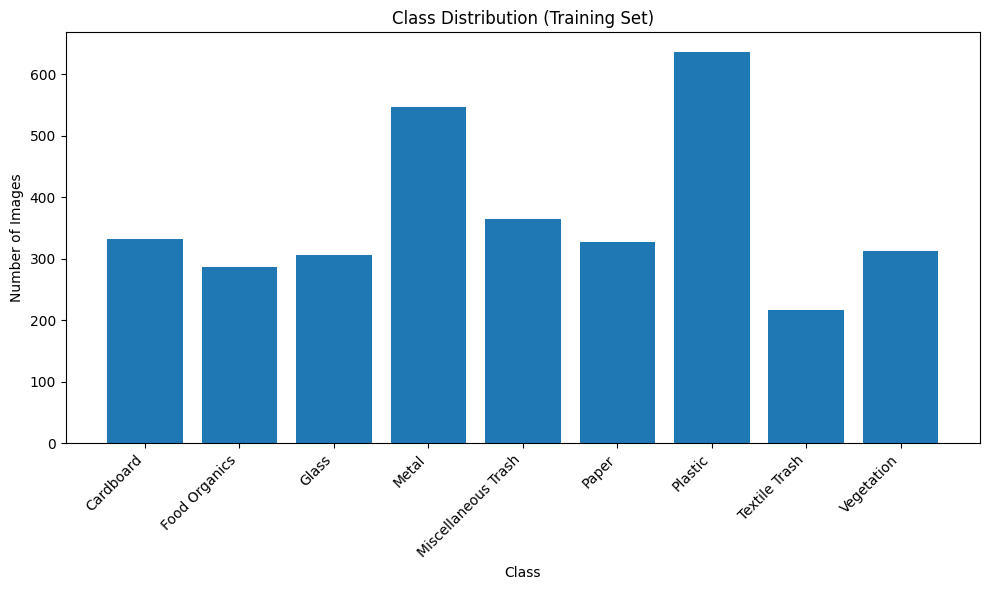

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the dataset
labels = train_ds.class_names
num_classes = len(labels)
counts = [0] * num_classes

# Iterate through the dataset to count images per class
for images, labels_batch in train_ds:
    for label in labels_batch.numpy():
        counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

# Prefetching and caching for performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Cache -keep data ready in memory.

Prefetch - prepare next batch while training.

AUTOTUNE - let TensorFlow choose the best prefetching speed.

In [44]:
# Normalize pixel values
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    print("Shape of images batch:", images.shape)
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())



Shape of images batch: (32, 128, 128, 3)
Min pixel value: 0.0
Max pixel value: 1.0


Since we are just doing min max normalization doesnt matter if we divide the dataset into traning set, validation ... before or after it.

When using standard normalization techniques also we have to first divide into sets since we only have to calculate the mean, standard deviation statistics on the test set and not all. Otherwise the model is going to fit the data in an unnecessary manner.

In [45]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization



Here using sequential we make the layers all in the sequential order.

In [46]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # slightly reduced to retain learning
    layers.Dense(num_classes, activation='softmax')
])



In [47]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
#Checking the labeling technique

for images, labels in train_ds.take(1):
    print(labels.numpy())


[3 1 6 6 6 4 3 2 2 4 6 3 0 3 0 8 4 8 1 6 1 6 7 1 6 3 6 8 4 3 8 6]


Since the above code is supposed to give the labels of the first batch ( train_ds.take(1) ) we expect 32 labels. But we got less than that. That is because we have used Prefetching / caching / shuffling. Therefore it gives a random batch and not the first one. And that could contain less than 32 images if the no of images is not divisable by 32.

The above labelling method is called the sparse_categorical_crossentropy.
[100000...] this is one hot encoding.

Since sparse_categorical_crossentropy is used here we use that loss function.

Like MSE is for regression, binary_cross_entropy for 2 class problems.

In [49]:
# configuring your model before training — how it should learn.

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [50]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 57s 329ms/step - accuracy: 0.4904 - loss: 1.7293 - val_accuracy: 0.0696 - val_loss: 8.0344
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.7776 - loss: 0.6775 - val_accuracy: 0.0696 - val_loss: 9.0515
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.8963 - loss: 0.3314 - val_accuracy: 0.0852 - val_loss: 4.7224
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.9732 - loss: 0.1361 - val_accuracy: 0.0866 - val_loss: 4.8480
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9895 - loss: 0.0622 - val_accuracy: 0.2926 - val_loss: 2.5675
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.9982 - loss: 0.0332 - val_accuracy: 0.5440 - val_loss: 1.6332
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9988 - loss: 0.0212 - val_accuracy: 0.6989 - val_loss: 0.9891
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9991 - loss: 0

Plotting training and validation accuracies

In [51]:
import matplotlib.pyplot as plt

In [52]:
# Extracting the history

# history is an object returned by model.fit() containing metrices tracked per epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


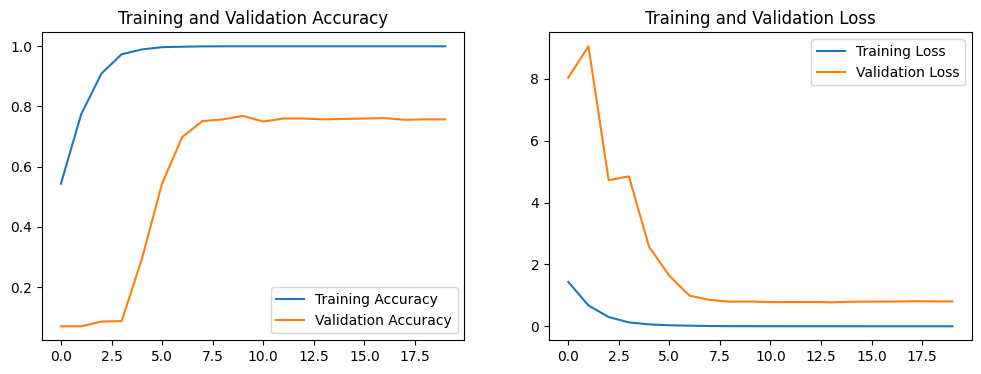

In [53]:
epochs_range = range(20)  # x axis range

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)  # 1 row, 2 columns, first plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)  # second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()




In [54]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.7368 - loss: 0.8897
Test Accuracy: 0.7364771366119385


### Confusion Matrix

Shows how many images of each class were correctly/misclassified

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


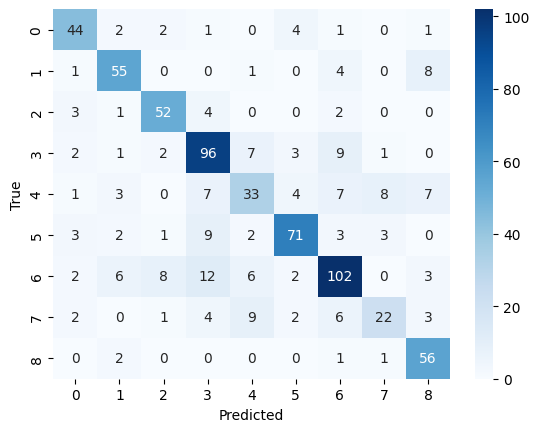

In [56]:
# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Comparing our network with state-of-the-art networks

In [57]:
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras import layers, models
